In [8]:
import numpy as np
import copy
#from simpy import var, solve
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors

# RHEA Thermodynamic calculator

In [9]:
class BaseThermodynamicModel:

  ###  Attributes
  R_universal      = 8.31446261815324      # Universal gas constant [j/(mol k)]
  R_specific       = -1.0                  # Specific gas constant [J/(kg K)]
  molecular_weight = -1.0                  # Molecular weight [kg/mol]
  gamma            = -1.0                  # Ratio of heat capacities [-]

  #####

  ### Constructor
  def __init__(self):
    pass

  ### Methods
  def calculatePressureFromTemperatureDensity(self, T, rho):
    
    return 0.0


  def calculateTemperatureFromPressureDensity(self, P, rho):

    return 0.0
  

  def calculateTemperatureFromPressureDensityWithInitialGuess(self, T, P, rho):

    return 0.0

  
  def calculateInternalEnergyFromPressureTemperatureDensity(self, P, T, rho):

    return 0.0


  def calculatePressureTemperatureFromDensityInternalEnergy(self, P, T, rho, e):

    return 0.0


  def calculateDensityInternalEnergyFromPressureTemperature(self, rho, e, P, T):

    return 0.0


  def calculateSpecificHeatCapacities(self, c_v, c_p, P, T, rho):

    return 0.0 


  def calculateHeatCapacitiesRatio(self, P, T, rho):

    return 0.0 


  def calculateSoundSpeed(self, P, T, rho):

    return 0.0


  def calculateVolumeExpansivity(self, T, bar_v):

    return 0.0


  def calculateIsothermalCompressibility(self, T, bar_v):

    return 0.0

  
  def calculateIsentropicCompressibility(self, P, T, bar_v):
  
    return 0.0

###################################################################
##################### IDEAL gas ###################################
###################################################################

class IdealGasModel(BaseThermodynamicModel):

  ###  Attributes

  ### Constructor
  def __init__(self, R_specific, gamma):
    super(BaseThermodynamicModel,self).__init__()  
    self.R_specific       = R_specific
    self.gamma            = gamma    
    self.molecular_weight = self.R_universal/self.R_specific

  ### Methods
  def calculatePressureFromTemperatureDensity(self, T, rho):

    # Equation of state
    P = rho*self.R_specific*T

    return P


  def calculateTemperatureFromPressureDensity(self, P, rho):
    
    # Equation of state
    T = P/(self.R_specific*rho)

    return T
  

  def calculateTemperatureFromPressureDensityWithInitialGuess(self, T, P, rho):

    # Equation of state
    T = P/(self.R_specific*rho)

    return T


  def calculateInternalEnergyFromPressureTemperatureDensity(self, P, T, rho):

    #Equation of Specific heat at constant volume
    c_v = self.R_specific/(self.gamma - 1.0)

    #Equation of Internal Energy 
    e = c_v*T

    return e


  def calculatePressureTemperatureFromDensityInternalEnergy(self, P, T, rho, e):

    c_v = self.R_specific/(self.gamma - 1.0)
    P = e*rho*(self.gamma - 1.0 )
    T = e/c_v

    return P, T


  def calculateDensityInternalEnergyFromPressureTemperature( self, rho, e, P, T):

    c_v = self.R_specific/(self.gamma - 1.0)

    e   = c_v*T
    rho = P/(e*(self.gamma - 1.0))

    return rho, e 


  def calculateSpecificHeatCapacities(self, c_v, c_p, P, T, rho):
  
    c_v = self.R_specific/(self.gamma - 1.0)
    c_p = c_v*self.gamma

    return c_v, c_p


  def calculateHeatCapacitiesRatio(self, P, rho):

    return self.gamma


  def calculateSoundSpeed(self, P, T, rho):

    sos = np.sqrt(self.gamma*P/(rho))

    return sos


  def calculateVolumeExpansivity(self, T, bar_v):

    expansivity = 1.0/T

    return expansivity


  def calculateIsothermalCompressibility(self, T, bar_v):

    isothermal_compressibility = bar_v/(self.molecular_weight*self.R_specific*T)

    return isothermal_compressibility


  def calculateIsentropicCompressibility(self, P, T, bar_v):

    dP_dT_const_v = self.molecular_weight*self.R_specific/bar_v
    dP_dv_const_T = (-1.0)*self.molecular_weight*self.R_specific*T/(bar_v*bar_v)

    isothermal_compressibility = ( -1.0 )/(bar_v*dP_dv_const_T)
    expansivity                = ( -1.0 )*(dP_dT_const_v/(bar_v*dP_dv_const_T))

    c_v = self.R_specific/(self.gamma - 1.0 )
    c_p = c_v*self.gamma

    bar_c_p = self.molecular_weight*c_p

    isentropic_compressibility = (isothermal_compressibility - ((bar_v*T*expansivity**2.0)/bar_c_p))

    return isentropic_compressibility
    

###################################################################
##################### REAL gas ####################################
###################################################################

class PengRobinsonModel(BaseThermodynamicModel):

  ### Atributes (Variables that don't change with temperature)
  acentric_factor               = -1.0   
  critical_temperature          = -1.0
  critical_pressure             = -1.0  
  critical_molar_volume         = -1.0
  NASA_coefficients             = (-1.0)*np.ones(15)
  eos_b                         = -1.0 
  eos_ac                        = -1.0
  eos_kappa                     = -1.0
  max_aitken_iter               = 1000
  aitken_relative_tolerance     = 1.0e-5
  ### Nonlinear solver parameters
  xtol   = 1.0e-10		# Relative error between two consecutive iterates
  epsfcn = 1.0e-5			# Step length for the forward-difference approximation of the Jacobian
  factor = 1.0e-1			# Parameter determining the initial step bound. Should be in the interval [0.1:100]

  ### Constructor

  def __init__(self, molecular_weight, acentric_factor, critical_temperature, critical_pressure, critical_molar_volume, NASA_coefficients):
    super(BaseThermodynamicModel,self).__init__()  
    self.molecular_weight           = molecular_weight
    self.R_specific                 = self.R_universal/molecular_weight     
    self.acentric_factor            = acentric_factor
    self.critical_temperature       = critical_temperature
    self.critical_pressure          = critical_pressure
    self.critical_molar_volume      = critical_molar_volume
    self.NASA_coefficients          = NASA_coefficients

    self.eos_b  = 0.077796*( self.R_universal*self.critical_temperature/self.critical_pressure )
    #print('eos_b: {}'.format(eos_b))

    self.eos_ac = 0.457236*(( self.R_universal*self.critical_temperature)**2.0/(self.critical_pressure))
    #print('eos_ac: {}'.format(eos_ac))

    if acentric_factor > 0.49:
      self.eos_kappa = 0.379642 + 1.48503*self.acentric_factor - 0.164423*self.acentric_factor**2.0 + 0.016666*self.acentric_factor**3.0 
    else:
      self.eos_kappa = 0.37464 + 1.54226*self.acentric_factor - 0.26992*self.acentric_factor**2.0


  ### Methods

  def n_solve( self, functions, variables, norm_factors ):
    func = lambda x : [ f(*x) for f in functions ]
    variables = fsolve( func, variables, xtol = self.xtol, epsfcn = self.epsfcn, factor = self.factor, diag = norm_factors )

    return variables


  def calculateTemperatureFromPressureDensity( self, P, rho ):

    # Calculate molar volume 
    bar_v = self.molecular_weight/rho
    
    # Calculate temperature guess using ideal-gas model
    T = P*bar_v/self.R_universal

    x_0 = T

    for iter in range(self.max_aitken_iter):
      x_1 = ((bar_v - self.eos_b) / self.R_universal) * (P + (self.calculate_eos_a(x_0) /((bar_v**2.0) + 2.0 * self.eos_b * bar_v - (self.eos_b**2.0))))
      x_2 = ((bar_v - self.eos_b) / self.R_universal) * (P + (self.calculate_eos_a(x_1) /((bar_v**2.0) + 2.0 * self.eos_b * bar_v - (self.eos_b**2.0))))
    
      denominator = x_2 - 2.0 * x_1 + x_0

      #T = x_2 - (pow(x_2 - x_1, 2.0)) / denominator
      T = x_2 - (x_2 - x_1)**2.0 / (denominator + 1.0e-10)
    
      if abs((T - x_2) / T) < self.aitken_relative_tolerance:
          break  # If the result is within tolerance, leave the loop!
          
      x_0 = T  # Otherwise, update x_0 to iterate again...
      
    return T


  def calculateTemperatureFromPressureDensityWithInitialGuess( self, T, P, rho ):

    ### Define functions
    functions = []
    functions.append( lambda variable_T : ( ( self.calculatePressureFromTemperatureDensity(variable_T,rho) ) - P )/P )

    ### Initialize variables: T
    variables = np.zeros( 1 )
    variables[0] = T    # Use input T value as initial guess

    ### Set normalization factors of Jacobian's diagonal: T
    norm_factors = np.zeros( 1 )
    norm_factors[0] = copy.deepcopy( abs( variables[0] ) )

    ### Solve nonlinear system
    variables = self.n_solve( functions, variables, norm_factors )
    #print( variables )

    ### Assign solution to T
    T = variables[0]
    #print( T)

    return T


  def calculateInternalEnergyFromPressureTemperatureDensity(self, P, T, rho):

    bar_v = self.molecular_weight/rho
    e = (1.0/self.molecular_weight)*self.calculateMolarInternalEnergyFromPressureTemperatureMolarVolume(P, T, bar_v)

    return e


  def calculatePressureTemperatureFromDensityInternalEnergy(self, P, T, rho, e):

    # Calculate molar volume 
    bar_v = self.molecular_weight/rho

    ### Define functions
    functions = []
    functions.append( lambda variable_P, variable_T : ( ( self.calculatePressureFromTemperatureDensity(variable_T,rho) ) - variable_P )/variable_P )
    functions.append( lambda variable_P, variable_T : ( ( self.calculateMolarInternalEnergyFromPressureTemperatureMolarVolume(variable_P,variable_T,bar_v)/self.molecular_weight ) - e )/e )

    ### Initialize variables: P & T
    variables = np.zeros( 2 )
    variables[0] = P    # Use input P value as initial guess
    variables[1] = T    # Use input T value as initial guess

    ### Set normalization factors of Jacobian's diagonal: P & T
    norm_factors = np.zeros( 2 )
    norm_factors[0] = copy.deepcopy( abs( variables[0] ) )
    norm_factors[1] = copy.deepcopy( abs( variables[1] ) )

    ### Solve nonlinear system
    variables = self.n_solve( functions, variables, norm_factors )
    #print( variables )

    ### Assign solution to P & T
    P = variables[0]
    T = variables[1]
    #print( P, T)

    return P, T


  def calculateDensityInternalEnergyFromPressureTemperature(self, rho, e, P, T):

    # Auxiliar parameters
    eos_a  = self.calculate_eos_a(T)
    eos_en = P*self.eos_b + self.R_universal*T
    a      = P
    b      = 2.0*P*self.eos_b - eos_en
    c      = (-1.0)*P*self.eos_b*self.eos_b - 2.0*eos_en*self.eos_b + eos_a
    d      = (-1.0)*self.eos_b*(eos_a + (-1.0)*eos_en*self.eos_b)

    # Cubic solve to calculate rho
    v_1, v_2, v_3 = self.calculateRootsCubicPolynomial(a, b, c, d)
    rho = self.molecular_weight/(v_1.real)     # First root is always real

    # Calculate e
    bar_v = self.molecular_weight/rho
    e = (1.0/self.molecular_weight)*self.calculateMolarInternalEnergyFromPressureTemperatureMolarVolume(P, T, bar_v)
    
    return rho, e


  def calculateSpecificHeatCapacities(self, c_v, c_p, P, T, rho):

    bar_v = self.molecular_weight/rho
    std_bar_c_p = self.calculateMolarStdCpFromNASApolynomials(T)
    std_bar_c_v = std_bar_c_p - self.R_universal
    
    c_v = (1.0/self.molecular_weight)*(std_bar_c_v + self.calculateDepartureFunctionMolarCv(P, T, bar_v))
    c_p = (1.0/self.molecular_weight)*(std_bar_c_p + self.calculateDepartureFunctionMolarCp(P, T, bar_v))

    return c_v, c_p


  def calculateHeatCapacitiesRatio(self, P, rho):
    
    bar_v = self.molecular_weight/rho
    T = self.calculateTemperatureFromPressureDensity(P, rho)
    std_bar_c_p = self.calculateMolarStdCpFromNASApolynomials(T)
    std_bar_c_v = std_bar_c_p - self.R_universal

    c_v = (1.0/self.molecular_weight) * (std_bar_c_v + self.calculateDepartureFunctionMolarCv(P, T, bar_v))
    c_p = (1.0/self.molecular_weight) * (std_bar_c_p + self.calculateDepartureFunctionMolarCp(P, T, bar_v))

    gamma = c_p/c_v
    
    return gamma


  def calculateSoundSpeed(self, P, T, rho):
    
    bar_v = self.molecular_weight/rho

    sos = np.sqrt( 1.0/(rho*self.calculateIsentropicCompressibility(P, T, bar_v)) )

    return sos
  

  def calculateVolumeExpansivity(self, T,bar_v ):

    dP_dT_const_v = self.calculateDPDTConstantMolarVolume(T,bar_v)
    dP_dv_const_T  = self.calculateDPDvConstantTemperature(T,bar_v)

    Expansivity = (-1.0)*(dP_dT_const_v/(bar_v*dP_dv_const_T))

    return Expansivity
  

  def calculateIsothermalCompressibility(self, T, bar_v):

    dP_dv_const_T = self.calculateDPDvConstantTemperature(T, bar_v)
    isothermal_compressibility = (-1.0)/(bar_v*dP_dv_const_T)

    return isothermal_compressibility
  

  def calculateIsentropicCompressibility(self, P, T, bar_v):

    isothermal_compressibility = self.calculateIsothermalCompressibility(T, bar_v)
    expansivity                = self.calculateVolumeExpansivity(T, bar_v)
    bar_c_p                    = self.calculateMolarStdCpFromNASApolynomials(T) + self.calculateDepartureFunctionMolarCp(P, T, bar_v)
      
    isentropic_compressibility = (isothermal_compressibility - ((bar_v * T * (expansivity ** 2.0)) / bar_c_p))
    
    return isentropic_compressibility
  

  def calculatePressureFromTemperatureDensity(self, T, rho):

    bar_v = self.molecular_weight/rho
    P = (self.R_universal*T/(bar_v - self.eos_b)) - (self.calculate_eos_a( T )/(bar_v*bar_v + 2.0*self.eos_b*bar_v - self.eos_b*self.eos_b))
    
    return P
  

  def calculateMolarInternalEnergyFromPressureTemperatureMolarVolume(self,P, T, bar_v):

    bar_e = self.calculateMolarStdEnthalpyFromNASApolynomials(T) + self.calculateDepartureFunctionMolarEnthalpy(P, T, bar_v) - P * bar_v
    
    return bar_e
    

  def calculate_eos_a( self, T ):
     
     eos_a = (0.457*((self.R_universal*self.critical_temperature)**2)/(self.critical_pressure))*(1+self.eos_kappa*(1-np.sqrt(T/self.critical_temperature)))**2
     
     return eos_a


  def calculate_eos_a_first_derivative(self, T):

    eos_a_first_derivative = self.eos_kappa*self.eos_ac*( ( self.eos_kappa/self.critical_temperature ) - ( ( 1.0 + self.eos_kappa )/np.sqrt(T*self.critical_temperature ) ) )
    # eos_a_first_derivative = eos_kappa*eos_ac*( ( eos_kappa/critical_temperature ) - ( ( 1.0 + eos_kappa )/sqrt( T*critical_temperature ) ) );
   
    return eos_a_first_derivative


  def calculate_eos_a_second_derivative(self, T):
 
    eos_a_second_derivative = (self.eos_kappa*self.eos_ac*(1.0 + self.eos_kappa))/(2.0*np.sqrt(T**3.0)*self.critical_temperature)

    return eos_a_second_derivative


  def calculate_Z(self, P, T,bar_v):

    Z = (P*bar_v)/(self.R_universal*T)

    return Z
  

  def calculate_A(self, P, T ):

    eos_a = self.calculate_eos_a( T )

    A = (eos_a*P)/((self.R_universal*T)**2.0)

    return A
  

  def calculate_B(self, P, T):
    
    B = (self.eos_b*P)/(self.R_universal*T)

    return B
  

  def calculate_M(self, Z, B):

    M = (Z**2+2.0*B*Z-B**2)/(Z - B)
    
    return M
  

  def calculate_N(self, eos_a_first_derivative, B):

    N = eos_a_first_derivative * (B/(self.eos_b*self.R_universal))

    return N
  

  def calculateMolarStdCpFromNASApolynomials(self, T):                          #### Acabar de definir els parametres del Nasa_coefficients 
    std_bar_c_p = 0.0
    if 200.0 <= T < 1000.0:
        std_bar_c_p = self.R_universal*(self.NASA_coefficients[7] + self.NASA_coefficients[8]*T + self.NASA_coefficients[9]*T**2.0 + self.NASA_coefficients[10]*T**3.0 + self.NASA_coefficients[11]* T**4.0)
    elif 1000.0 <= T < 6000.0:
        std_bar_c_p = self.R_universal*(self.NASA_coefficients[0] + self.NASA_coefficients[1]*T + self.NASA_coefficients[2]*T**2.0 + self.NASA_coefficients[3]*T**3.0 + self.NASA_coefficients[4]* T**4.0)
    elif T < 200:
        # Assume constant temperature below T = 200 K	    
        T_min = 200.0	    
        std_bar_c_p = self.R_universal*(self.NASA_coefficients[7] + self.NASA_coefficients[8]*T_min + self.NASA_coefficients[9]*T_min**2.0 + self.NASA_coefficients[10]*T_min**3.0 + self.NASA_coefficients[11]*T_min**4.0)
    else:
        print(f"\nNASA 7-coefficient polynomials for std bar c_p. T = {T} is above 6000 K.\n\n")
        exit()
    return std_bar_c_p
      
  def calculateMolarStdEnthalpyFromNASApolynomials(self, T):
    std_bar_h = 0.0

    if T >= 200.0 and T < 1000.0:
      #std_bar_h = R_universal*T*( NASA_coefficients[7] + NASA_coefficients[8]*T/2.0 + NASA_coefficients[9]*pow( T, 2.0 )/3.0 + NASA_coefficients[10]*pow( T, 3.0 )/4.0 + NASA_coefficients[11]*pow( T, 4.0 )/5.0 + NASA_coefficients[12]/T) - R_universal*NASA_coefficients[14];
      std_bar_h = self.R_universal*T*( self.NASA_coefficients[7] + self.NASA_coefficients[8]*T/2.0 + self.NASA_coefficients[9]*(T**2.0)/3.0 + self.NASA_coefficients[10]*(T**3.0)/4.0 + self.NASA_coefficients[11]*(T**4.0)/5.0 + self.NASA_coefficients[12]/T )
    elif T >= 1000.0 and T < 6000.0:
      #//std_bar_h = R_universal*T*( NASA_coefficients[0] + NASA_coefficients[1]*T/2.0 + NASA_coefficients[2]*pow( T, 2.0 )/3.0 + NASA_coefficients[3]*pow( T, 3.0 )/4.0 + NASA_coefficients[4]*pow( T, 4.0 )/5.0 + NASA_coefficients[5]/T ) - R_universal*NASA_coefficients[14];
      std_bar_h = self.R_universal*T*( self.NASA_coefficients[0] + self.NASA_coefficients[1]*T/2.0 + self.NASA_coefficients[2]*(T**2.0)/3.0 + self.NASA_coefficients[3]*(T**3.0)/4.0 + self.NASA_coefficients[4]*(T**4.0)/5.0 + self.NASA_coefficients[5]/T )
    elif T < 200.0:
      T_min = 200.0

      #std_bar_h_min   = R_universal*T_min*( NASA_coefficients[7] + NASA_coefficients[8]*T_min/2.0 + NASA_coefficients[9]*pow( T_min, 2.0 )/3.0 + NASA_coefficients[10]*pow( T_min, 3.0 )/4.0 + NASA_coefficients[11]*pow( T_min, 4.0 )/5.0 + NASA_coefficients[12]/T_min ) - R_universal*NASA_coefficients[14];
      std_bar_h_min   = self.R_universal*T_min*( self.NASA_coefficients[7] + self.NASA_coefficients[8]*T_min/2.0 + self.NASA_coefficients[9]*(T_min**2.0)/3.0 + self.NASA_coefficients[10]*(T_min**3.0)/4.0 + self.NASA_coefficients[11]*(T_min**4.0)/5.0 + self.NASA_coefficients[12]/T_min )
      std_bar_h_slope = self.R_universal*( self.NASA_coefficients[7] + self.NASA_coefficients[8]*T_min + self.NASA_coefficients[9]*(T_min**2.0) + self.NASA_coefficients[10]*(T_min**3.0) + self.NASA_coefficients[11]*T_min**4.0)
      std_bar_h = std_bar_h_min + std_bar_h_slope*(T-T_min)
      
    else:
       
       print(f"\nNASA 7-coefficient polynomials for std bar c_p. T = {T} is above 6000 K.\n\n")
       exit()

    return std_bar_h


  def calculateDepartureFunctionMolarCp(self, P, T, bar_v):
    # Peng-Robinson model:
    # D.Y. Peng, D. B. Robinson 
    # A new two-constants equation of state
    # Industrial and Engineering Chemistry: Fundamental , 15 , 59-64 , 1976.

    eos_a_first_derivative  = self.calculate_eos_a_first_derivative( T )
    eos_a_second_derivative = self.calculate_eos_a_second_derivative ( T )
    Z                       = self.calculate_Z(P, T, bar_v)
    A                       = self.calculate_A(P, T)
    B                       = self.calculate_B(P, T)
    M                       = self.calculate_M(Z, B)
    N                       = self.calculate_N(eos_a_first_derivative, B)

    Delta_bar_c_p = ((self.R_universal*(M - N)**2))/((M**2.0) - 2.0*A* (Z + B)) - ((T*eos_a_second_derivative)/(2.0*np.sqrt(2.0)*self.eos_b))*np.log((Z + (1.0 - np.sqrt(2.0))*B)/(Z + (1.0 + np.sqrt(2.0))*B)) - self.R_universal
    
    return Delta_bar_c_p


  def calculateDepartureFunctionMolarCv(self, P, T, bar_v):

    eos_a_second_derivative = self.calculate_eos_a_second_derivative( T )
    Z                       = self.calculate_Z(P, T, bar_v)
    B                       = self.calculate_B(P, T)

    Delta_bar_c_v = (-1.0)*((T*eos_a_second_derivative)/(2.0*np.sqrt( 2.0)*self.eos_b))*np.log((Z+(1.0 - np.sqrt( 2.0 ))*B)/(Z+(1.0 + np.sqrt(2.0))*B))
    
    return Delta_bar_c_v


  def calculateDepartureFunctionMolarEnthalpy(self, P, T, bar_v):
    # Peng-Robinson model 
    # D. Y. Peng, D. B. Robinson 
    # A new two-constant equations of State
    # Industrial and engineering Chemistry: Fundamental, 15, 59-64 , 1976.
    eos_a                    = self.calculate_eos_a( T )
    eos_a_first_derivative   = self.calculate_eos_a_first_derivative( T )
    Z                        = self.calculate_Z(P, T, bar_v)
    B                        = self.calculate_B(P, T)

    Delta_bar_h = self.R_universal*T*(Z - 1.0) + (( eos_a - eos_a_first_derivative*T)/(2.0*np.sqrt(2.0)*self.eos_b))*np.log((Z + (1.0 - np.sqrt(2.0))*B)/(Z + (1.0 + np.sqrt(2.0))*B))
    
    return Delta_bar_h
  

  def calculateTemperatureFromPressureMolarVolume(self, P, bar_v):

    # Initial temperature guess using ideal-gas model
    T = P*bar_v/self.R_universal
        
    # Aitken’s delta-squared process:
    x_0 = T

    for iter in range(self.max_aitken_iter):
      x_1 = ((bar_v - self.eos_b) / self.R_universal) * (P + (self.calculate_eos_a(x_0) / (bar_v**2 + 2*self.eos_b*bar_v - self.eos_b**2)))
      x_2 = ((bar_v - self.eos_b) / self.R_universal) * (P + (self.calculate_eos_a(x_1) / (bar_v**2 + 2*self.eos_b*bar_v - self.eos_b**2)))

      denominator = x_2 - 2*x_1 + x_0
      T = x_2 - ((x_2 - x_1)**2) / denominator

      if abs((T - x_2) / T) < self.aitken_relative_tolerance:
        break	# If the result is within tolerance, leave the loop!
            
        x_0 = T	# Otherwise, update x_0 to iterate again ...

    return T

  
  def calculateDPDTConstantMolarVolume(self, T, bar_v):

    eos_a_first_derivative  = self.calculate_eos_a_first_derivative( T )

    dP_dT_const_v = (self.R_universal/(bar_v - self.eos_b))-(eos_a_first_derivative/(bar_v*bar_v + 2.0*bar_v*self.eos_b - self.eos_b*self.eos_b))

    return dP_dT_const_v


  def calculateDPDvConstantTemperature(self, T, bar_v):

    eos_a = self.calculate_eos_a( T )

    dP_dv_const_T = (-1.0)*((self.R_universal*T)/(bar_v-self.eos_b)**2) + (eos_a*(2.0*bar_v + 2.0*self.eos_b))/((bar_v**2.0) + 2.0*bar_v*self.eos_b - self.eos_b**2.0)**2.0
    
    return dP_dv_const_T


  def calculateRootsCubicPolynomial( self, a, b, c, d):
    
    if a == 0:
      print("The coefficient of the cube of x is 0. Please use the utility for a SECOND degree quadratic. No further action taken.")
      return None, None, None                                                   # To define a null number 

    if d == 0:
      print("One root is 0. Now divide through by x and use the utility for a SECOND degree quadratic to solve the resulting equation for the other two roots. No further action taken.")
      return None, None, None                                                   # To define a null number

    b /= a                                                                      # normalize all coeficients value of the cubic equation                                                                            
    c /= a                                                                      # normalize all coeficients value of the cubic equation 
    d /= a                                                                      # normalize all coeficients value of the cubic equation 

    disc, q, r, dum1, s, t, term1, r13 = 0, 0, 0, 0, 0, 0, 0, 0                 #intermediate parameters of the roots
    q = (3.0*c - (b*b))/9.0
    r = -(27.0*d) + b*(9.0*c - 2.0*(b*b))
    r /= 54.0
    disc = q*q*q + r*r

    term1 = b/3.0

    if disc > 0:
      s = r + np.sqrt(disc)
      if s < 0:
        s = (-1.0)*( (-s)**(1.0/3.0) )
      else:
        s = s**(1.0/3.0)
      t = r - np.sqrt(disc)
      if t < 0:
        t = (-1.0)*( (-t)**(1.0/3.0) ) 
      else:
        t = t**(1.0/3.0) 
      root_1 = complex( (-1.0)*term1 + s + t, 0.0) 
      term1 += (s + t)/2.0
      term1  = np.sqrt(3.0)*(-t+s)/2
      root_2 = complex( (-1.0)*( b/3.0 + (s + t)/2.0 ), term1 )
      root_3 = complex( (-1.0)*( b/3.0 + (s + t)/2.0 ), (-1.0)*term1 )
      #print(root_1.real)
      #print(root_2.real)
      #print(root_3.real)
      return root_1, root_2, root_3
      
    # End if (disc > 0)
    print()
    print("The PengRobinsonModel::calculateRootsCubicPolynomial has found more than one real root.")
    print("Vapor-liquid equilibrium conditions must be solved.")
    print("Another option is to avoid calculating rho from P and T.")
    print()

    root_1 = complex( 0.0, 0.0 )
    root_2 = complex( 0.0, 0.0 )
    root_3 = complex( 0.0, 0.0 )

    return root_1, root_2, root_3


################################################################################
######################### BASE TRANSPORT COEFICIENTS ###########################
################################################################################


class BaseTransportCoefficients:				#### Base transport coefficients

  ### Atributes (Variables that don't change with temperature)
  R_universal      = 8.31446261815324      # Universal gas constant [j/(mol k)]
  #R_specific       = -1.0                  # Specific gas constant [J/(kg K)]
  #molecular_weight = -1.0                  # Molecular weight [kg/mol]
  mu_value         = -1.0                  # Dynamic viscosity [Pa·s]
  kappa_value      = -1.0                  # Thermal Conductivity [ W/(m·K)]

  ### Constructor 

  def __init__(self, R_universal):
    self.R_universal           = R_universal 


  ### Methods 

  def calculateDynamicViscosity(self, P, T, rho):

    return 0.0

  def calculateThermalConductivity(self, P, T, rho): 

    return 0.0 


class ConstantTransportCoefficients(BaseTransportCoefficients):                 ### Constant transport coefficients

  ### Constructor
  def __init__(self, mu, kappa):
    super(BaseTransportCoefficients,self).__init__()
    self.mu       = mu 
    self.kappa    = kappa 

  

  ### Methods

  def calculateDynamicViscosity(self, P, T, rho):
    
    return( self.mu )

  def calculateThermalConductivity(self, P, T, rho):
    
    return( self.kappa )
  

class LowPressureGasTransportCoefficients(BaseTransportCoefficients):           ### Low-pressure gas variable transport coefficients

  ### Atributes (Variables that don't change with temperature)
  mu_0        = -1.0
  kappa_0     = -1.0 
  T_0         = -1.0 
  S_mu        = -1.0
  S_kappa     = -1.0 

  ### Constructor 

  def __init__(self, mu_0, kappa_0, T_0, S_mu, S_kappa):
    super(BaseTransportCoefficients,self).__init__()  
    self.mu_0    =  mu_0
    self.kappa_0 = kappa_0
    self.T_0     = T_0
    self.S_mu    = S_mu 
    self.S_kappa = S_kappa

  def calculateDynamicViscosity(self, P, T, rho):

    return ((self.mu_0*(T/self.T_0)**1.5)*((self.T_0 + self.S_mu)/(T + self.S_mu)))

  
  def calculateThermalConductivity(self, P, T, rho):

    return (self.kappa_0*((T/self.T_0)**1.5))*((self.T_0 + self.S_kappa)/(T + self.S_kappa))


class HighPressureTransportCoeficients(BaseTransportCoefficients):              ### High-pressure transport coefficients

  ### Atributes (Variables that don't change with temperature)

  molecular_weight                = -1.0 
  critical_temperature            = -1.0
  critical_molar_volume           = -1.0
  acentric_factor                 = -1.0
  dipole_moment                   = -1.0
  association_factor              = -1.0
  NASA_coefficients               = (-1.0)*np.ones(15)

  ### Constructor

  def __init__(self, molecular_weight, acentric_factor, critical_temperature, critical_molar_volume, NASA_coefficients, dipole_moment,association_factor):
    super(BaseTransportCoefficients,self).__init__()  
    self.molecular_weight           = molecular_weight
    self.critical_temperature       = critical_temperature
    self.critical_molar_volume      = critical_molar_volume   
    self.acentric_factor            = acentric_factor
    self.dipole_moment              = dipole_moment
    self.association_factor         = association_factor  
    self.NASA_coefficients          = NASA_coefficients
    
    
    ### Adimensional dipole moment -- Poling et al. The properties of gases and liquids. McGraw-Hill, 2001.
    self.adimensional_dipole_moment = 131.3*( self.dipole_moment/np.sqrt( ( 1.0e6*self.critical_molar_volume )*self.critical_temperature ) )
      
    ### Viscosity mu -- Poling et al. The properties of gases and liquids. McGraw-Hill, 2001. (9.40, Table 9-6)
    a1_mu  = 6.324;   a2_mu  = 1.210e-3;    a3_mu  = 5.283;   a4_mu  = 6.623;   a5_mu  = 19.745    
    a6_mu  = -1.900;  a7_mu  = 24.275;      a8_mu  = 0.7972;  a9_mu  = -0.2382; a10_mu = 0.06863   
    ####### Intenta posar-ho així perque 
    b1_mu  = 50.412;  b2_mu  = -1.154e-3 ; b3_mu  = 254.209;  b4_mu  = 38.096 ;  b5_mu  = 7.630;   b6_mu  = -12.537; b7_mu  = 3.450;  b8_mu  = 1.117;   b9_mu  = 0.06770; b10_mu = 0.3479; c1_mu  = -51.680; c2_mu  = -6.257e-3;  c3_mu  = -168.48; c4_mu  = -8.464; d10_mu = -0.727;
    c5_mu  = -14.354; c6_mu  = 4.985     ; c7_mu  = -11.291;  c8_mu  = 0.01235;  c9_mu  = -0.8163; c10_mu = 0.5926 ; d1_mu  = 1189.0; d2_mu  = 0.03728; d3_mu  = 3898.0;  d4_mu = 31.42;   d5_mu  = 31.53;   d6_mu  = -18.15;     d7_mu  = 69.35;   d8_mu  = -4.117; d9_mu  = 4.025;

    self.E1_mu  = a1_mu  + b1_mu*self.acentric_factor  + c1_mu*self.adimensional_dipole_moment**4.0  + d1_mu*self.association_factor
    self.E2_mu  = a2_mu  + b2_mu*self.acentric_factor  + c2_mu*self.adimensional_dipole_moment**4.0  + d2_mu*self.association_factor
    self.E3_mu  = a3_mu  + b3_mu*self.acentric_factor  + c3_mu*self.adimensional_dipole_moment**4.0  + d3_mu*self.association_factor
    self.E4_mu  = a4_mu  + b4_mu*self.acentric_factor  + c4_mu*self.adimensional_dipole_moment**4.0  + d4_mu*self.association_factor
    self.E5_mu  = a5_mu  + b5_mu*self.acentric_factor  + c5_mu*self.adimensional_dipole_moment**4.0  + d5_mu*self.association_factor
    self.E6_mu  = a6_mu  + b6_mu*self.acentric_factor  + c6_mu*self.adimensional_dipole_moment**4.0  + d6_mu*self.association_factor
    self.E7_mu  = a7_mu  + b7_mu*self.acentric_factor  + c7_mu*self.adimensional_dipole_moment**4.0  + d7_mu*self.association_factor
    self.E8_mu  = a8_mu  + b8_mu*self.acentric_factor  + c8_mu*self.adimensional_dipole_moment**4.0  + d8_mu*self.association_factor
    self.E9_mu  = a9_mu  + b9_mu*self.acentric_factor  + c9_mu*self.adimensional_dipole_moment**4.0  + d9_mu*self.association_factor
    self.E10_mu = a10_mu + b10_mu*self.acentric_factor + c10_mu*self.adimensional_dipole_moment**4.0 + d10_mu*self.association_factor

    ### Thermal conductivity k -- Poling et al. The properties of gases and liquids. McGraw-Hill, 2001. (10.23, Table 10-3)
    a1_k = 2.4166*1.00;  a3_k = 6.6107*1.00; a5_k = 7.9274*0.10; a7_k = 9.1089*10.0;  b2_k = -1.5094*1.00; b4_k = -8.9139*1.00; b6_k = 1.2801*10.00; c1_k = -9.1858*0.10; c3_k = 6.4760*10.00; c5_k = -6.9369*0.10; c7_k = -5.4217*10.0; d2_k = 6.9983*10.00; d4_k = 7.4344*10.00; d6_k = 6.5529*10.00
    a2_k = -5.0924*0.1;  a4_k = 1.4543*10.0; a6_k = -5.8634*1.0; b1_k = 7.4824*0.100; b3_k = 5.6207*1.000; b5_k = 8.2019*0.100; b7_k = 1.2811*100.0; c2_k = -4.9991*10.0; c4_k = -5.6379*1.00; c6_k = 9.5893*1.000; d1_k = 1.2172*100.0; d3_k = 2.7039*10.00; d5_k = 6.3173*1.000; d7_k = 5.2381*100.0

    self.B1_k = a1_k + b1_k*self.acentric_factor + c1_k*self.adimensional_dipole_moment**4.0 + d1_k*self.association_factor
    self.B2_k = a2_k + b2_k*self.acentric_factor + c2_k*self.adimensional_dipole_moment**4.0 + d2_k*self.association_factor
    self.B3_k = a3_k + b3_k*self.acentric_factor + c3_k*self.adimensional_dipole_moment**4.0 + d3_k*self.association_factor
    self.B4_k = a4_k + b4_k*self.acentric_factor + c4_k*self.adimensional_dipole_moment**4.0 + d4_k*self.association_factor
    self.B5_k = a5_k + b5_k*self.acentric_factor + c5_k*self.adimensional_dipole_moment**4.0 + d5_k*self.association_factor
    self.B6_k = a6_k + b6_k*self.acentric_factor + c6_k*self.adimensional_dipole_moment**4.0 + d6_k*self.association_factor
    self.B7_k = a7_k + b7_k*self.acentric_factor + c7_k*self.adimensional_dipole_moment**4.0 + d7_k*self.association_factor

  ### Methods 

  def calculateDynamicViscosity(self, P, T, rho):

    # T. H. Chung, L. L. Lee, K. E. Starling.
    # Applications of kinetic gas theories and multiparameter correlation for prediction of dilute gas viscosity and thermal conductivity.
    # Industrial & Engineering Chemistry Fundamentals, 23, 8-13, 1984.

    # T. H. Chung, M. Ajlan, L. L. Lee, K. E. Starling.
    # Generalized multiparameter correlation for nonpolar and polar fluid transport properties.
    # Industrial & Engineering Chemistry Fundamentals, 27, 671-679, 1988.

    # Auxiliar coefficients

   # rho = self.calculateDensityInternalEnergyFromPressureTemperature( P, T)     ### Call rho calculate in one method of BaseThermodynamics model
    #T   = self.                                                                 ### Call T calculate in one method of BaseThermodynamics model

    v     = self.molecular_weight/rho
    Y     = self.critical_molar_volume/( 6.0*v )
    T_ast = 1.2593*( T/self.critical_temperature )
    Omega = 1.16145*T_ast**(-0.14874)  + 0.52487*np.exp( -0.77320*T_ast ) + 2.16178*np.exp( -2.43787*T_ast )
    G1    = ( 1.0 - 0.5*Y )/((1.0 - Y)**3.0)
    Fc    = 1.0 - 0.2756*self.acentric_factor + 0.059035*self.adimensional_dipole_moment**4.0 + self.association_factor
    
    # Additional auxiliar coefficients

    G2_mu      = ( self.E1_mu*( 1.0 - np.exp( -self.E4_mu*Y ) )/Y + self.E2_mu*G1*np.exp( self.E5_mu*Y ) + self.E3_mu*G1 )/( self.E1_mu*self.E4_mu + self.E2_mu + self.E3_mu )
    mu_ast_ast = (self.E7_mu*Y**2.0)*G2_mu*np.exp( (self.E8_mu + self.E9_mu/T_ast) + self.E10_mu*T_ast**(-2.0))
    mu_ast     = ( np.sqrt( T_ast )*Fc/Omega )*( 1.0/G2_mu + self.E6_mu*Y ) + mu_ast_ast

    # Calculate viscosity
    mu = (1.0e-7)*mu_ast*( ( 36.344*np.sqrt( ( 1.0e3*self.molecular_weight )*self.critical_temperature ) )/ (1.0e6*self.critical_molar_volume)**(2.0/3.0)) 

    return( mu )
  

  def calculateThermalConductivity(self, P, T, rho): 

    # T. H. Chung, L. L. Lee, K. E. Starling.
    # Applications of kinetic gas theories and multiparameter correlation for prediction of dilute gas viscosity and thermal conductivity.
    # Industrial & Engineering Chemistry Fundamentals, 23, 8-13, 1984.

    # T. H. Chung, M. Ajlan, L. L. Lee, K. E. Starling.
    # Generalized multiparameter correlation for nonpolar and polar fluid transport properties.
    # Industrial & Engineering Chemistry Fundamentals, 27, 671-679, 1988.

    # Auxiliar coefficients

    std_bar_c_p =  self.calculateMolarStdCpFromNASApolynomials(T)

    v           = self.molecular_weight/rho
    Y           = self.critical_molar_volume/( 6.0*v )
    T_ast       = 1.2593*( T/self.critical_temperature )
    Omega       = 1.16145*pow( T_ast, -0.14874 ) + 0.52487*np.exp( -0.77320*T_ast ) + 2.16178*np.exp( -2.43787*T_ast )
    G1          = ( 1.0 - 0.5*Y )/pow( 1.0 - Y, 3.0 )
    Fc          = 1.0 - 0.2756*self.acentric_factor + 0.059035*pow( self.adimensional_dipole_moment, 4.0 ) + self.association_factor
    std_bar_c_p = self.calculateMolarStdCpFromNASApolynomials( T )

    # Additional auxiliar coefficients
    mu_0_k  = 40.785e-7*Fc*np.sqrt( 1.0e3*self.molecular_weight*T )/( pow( 1.0e6*self.critical_molar_volume, 2.0/3.0 )*Omega )
    alpha_k = ( std_bar_c_p/self.R_universal - 1.0 ) - 1.5                                                                                   
    beta_k  = 0.7862 - 0.7109*self.acentric_factor + 1.3168*pow( self.acentric_factor, 2.0 )
    gamma_k = 2.0 + 10.5*pow( T/self.critical_temperature, 2.0 )
    Psi_k   = 1.0 + alpha_k*( ( 0.215 + 0.28288*alpha_k - 1.061*beta_k + 0.26665*gamma_k )/( 0.6366 + beta_k*gamma_k + 1.061*alpha_k*beta_k) )
    q_k     = 0.003586*( np.sqrt( self.critical_temperature/self.molecular_weight )/pow( ( 1.0e6*self.critical_molar_volume ), 2.0/3.0 ) )
    G3_k    = ( ( ( self.B1_k/Y )*( 1.0 - np.exp( (-1.0)*self.B4_k*Y ) ) ) + ( self.B2_k*G1*np.exp( self.B5_k*Y ) ) + ( self.B3_k*G1 ) )/( self.B1_k*self.B4_k + self.B2_k + self.B3_k )

    # Calculate thermal conductivity
    kappa = ( 31.2*mu_0_k*Psi_k/self.molecular_weight )*( 1.0/G3_k + self.B6_k*Y ) + q_k*self.B7_k*pow( Y, 2.0 )*np.sqrt( T/self.critical_temperature)*G3_k

    return( kappa )
  

  def calculateMolarStdCpFromNASApolynomials(self, T): 

    std_bar_c_p = 0.0
    if (T>=200.0) and (T<1000.0) :
        std_bar_c_p = self.R_universal*(self.NASA_coefficients[7] + self.NASA_coefficients[8]*T + self.NASA_coefficients[9]*T**2.0 + self.NASA_coefficients[10]*T**3.0 + self.NASA_coefficients[11]* T**4.0)
    elif (T>=1000.0) and (T<6000.0):
        std_bar_c_p = self.R_universal*(self.NASA_coefficients[0] + self.NASA_coefficients[1]*T + self.NASA_coefficients[2]*T**2.0 + self.NASA_coefficients[3]*T**3.0 + self.NASA_coefficients[4]*T**4.0)
    elif (T < 200):
        # Assume constant temperature below T = 200 K	    
        T_min = 200.0	    
        std_bar_c_p = self.R_universal*(self.NASA_coefficients[7] + self.NASA_coefficients[8]*T_min + self.NASA_coefficients[9]*T_min**2.0 + self.NASA_coefficients[10]*T_min**3.0 + self.NASA_coefficients[11]*T_min**4.0)
    else:
        print(f"\nNASA 7-coefficient polynomials for std bar c_p. T = {T} is above 6000 K.\n\n")
        exit()
    return std_bar_c_p
  


# Definition of flow caracteristics

In [126]:
#List of constants
kinematic_viscosity = 1e-8 #approximate value of kinematic viscosity for CO2 in m2/s
diffusion_coefficient = 1e-9 #approximate value of diffusion coefficient for CO2 in m2/s, to check
schmidt_number = kinematic_viscosity/diffusion_coefficient

In [26]:
#Functions that returns lists of linearly spaced values for Re, L, U, T, Pr...(to complete)
def Re_list_generator(Re_min, Re_max, Re_number_of_points = 1000):
    return np.linspace(Re_min, Re_max, Re_number_of_points)

def Pr_list_generator(Pr_carac_min, Pr_carac_max, Pr_carac_number_of_points = 1000):
    return np.linspace(Pr_carac_min, Pr_carac_max, Pr_carac_number_of_points)

def L_list_generator(L_min, L_max, L_number_of_points = 1000):
    return np.linspace(L_min, L_max, L_number_of_points)

def U_list_generator(U_min, U_max, U_number_of_points = 1000):
    return np.linspace(U_min, U_max, U_number_of_points)

def T_carac_list_generator(T_carac_min, T_carac_max, T_carac_number_of_points = 1000):
    return np.linspace(T_carac_min, T_carac_max, T_carac_number_of_points)

def P_list_generator(P_min, P_max, P_number_of_points = 1000):
    return np.linspace(P_min, P_max, P_number_of_points)

def T_list_generator(T_min, T_max, T_number_of_points = 1000):
    return np.linspace(T_min, T_max, T_number_of_points)

In [54]:
#Generate here the lists for calculation, modify ranges and number of points here as desired
Re_list = Re_list_generator(Re_min = 1e0, Re_max = 1e4, Re_number_of_points = 1000)
L_list = L_list_generator(L_min = 1e-6, L_max = 1e-3, L_number_of_points = 1000) #Caracteristic length of flow  in meters
T_carac_list = T_carac_list_generator(T_carac_min = 1e-3, T_carac_max = 1e0, T_carac_number_of_points = 1000) #Caracteristic timescale of flow in seconds
U_list = U_list_generator(U_min = 1e-1, U_max = 2, U_number_of_points = 1000) #Caracteristic speed of flow in m.s-1

In [55]:
#Defines System variables with regards to previously given ones
#Re_list = U_list*L_list/kinematic_viscosity #Defines Re approximate for given range of U and L
#T_carac_list = L_list/U_list

# Kolmogorov scale approximate

## Kolmogorov length scale approximate

### Kolmogorv lengthscale approximate plot depending on Re and caracteristic lengthscale L of system

In [56]:
def calculate_approx_kolm_lengthscale_RevsL(Re_list, L_list):
    """
    Function that calculates the approximate Kolmogorov lengthscale for a given range of L and Re.
    
    Input:
    - Re_list: Array of Reynolds numbers
    - L_list: Array of characteristic length values (in meters)
    
    Output:
    - eta_array: Array of Kolmogorov lengthscale (approximate) for each pair of Re and L values (in micrometers)
    """
    # Reshape the arrays for calculation
    Re_list_reshaped = np.reshape(Re_list, (len(Re_list), 1))
    L_list_reshaped = np.reshape(L_list, (len(L_list), 1))

    # Calculate Kolmogorov lengthscale with eta ≈ L / (Re^0.75)
    Re_list_reshaped_raised_to_power = Re_list_reshaped**(-0.75)
    eta_array = L_list_reshaped @ Re_list_reshaped_raised_to_power.T
    
    # Convert to micrometers
    eta_array = eta_array * 1e6
    
    return eta_array


In [57]:
def plot_kolm_lengthscale_RevsL(Re_list, L_list, eta_array, Re_log_scale=True, L_log_scale=True, eta_log_scale=True, colormap='jet', nbr_of_contours=10):
    """
    Function that plots a colormap of the approximate Kolmogorov lengthscale for a given range of L and Re.
    
    Input:
    - Re_list: Array of Reynolds numbers
    - L_list: Array of characteristic length values (in meters)
    - eta_array: Array of Kolmogorov lengthscale values (in micrometers)
    - Re_log_scale: Boolean indicating whether to use a logarithmic scale for the Re axis (default: True)
    - L_log_scale: Boolean indicating whether to use a logarithmic scale for the L axis (default: True)
    - eta_log_scale: Boolean indicating whether to use a logarithmic scale for the eta colormap (default: True)
    - colormap: Name of the colormap (default: 'jet')
    - nbr_of_contours: Number of contour levels for the colormap (default: 10)
    """
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Create the filled contour plot
    if eta_log_scale:
        fig = plt.contourf(Re_list, L_list, eta_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(Re_list, L_list, eta_array, levels=nbr_of_contours, cmap=colormap)

    # Format function for scientific notation on the axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)
    
    if Re_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if L_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Kolmogorov lengthscale (µm)', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Approximate Kolmogorov lengthscale')
    ax.set_xlabel('Re')
    ax.set_ylabel('L (m)')

    # Show the plot
    plt.show()

In [58]:
eta_array = calculate_approx_kolm_lengthscale_RevsL(Re_list, L_list)

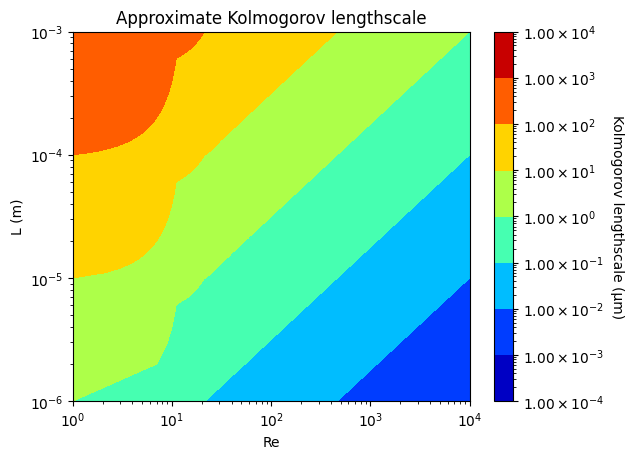

In [59]:
plot_kolm_lengthscale_RevsL(Re_list, L_list, eta_array, Re_log_scale = True, L_log_scale = True, eta_log_scale = True, colormap = 'jet', nbr_of_contours=10)

### Kolmogorv lengthscale approximate plot depending on U and caracteristic lengthscale L of system

In [60]:
def calculate_approx_kolm_lengthscale_UvsL(U_list, L_list, kinematic_viscosity):
    """
    Function that calculates the approximate Kolmogorov lengthscale for a given range of L and U.
    
    Input:
    - U_list: Array of characteristic speed values (in m/s)
    - L_list: Array of characteristic length values (in meters)
    - kinematic_viscosity: Kinematic viscosity of the fluid (in m^2/s)
    
    Output:
    - eta_array: Array of Kolmogorov lengthscale (approximate) for each pair of U and L values (in micrometers)
    """
    # Reshape the arrays for calculation
    U_list_reshaped = np.reshape(U_list, (len(U_list), 1))
    L_list_reshaped = np.reshape(L_list, (len(L_list), 1))

    # Calculate Kolmogorov lengthscale with eta ≈ (mu^3 * L / U^3)^0.25
    numerator = (kinematic_viscosity**3) * L_list_reshaped
    denominator = U_list_reshaped**-3
    eta_array = (numerator @ denominator.T) ** 0.25
    
    # Convert to micrometers
    eta_array = eta_array * 1e6
    
    return eta_array


In [61]:
eta_array = calculate_approx_kolm_lengthscale_UvsL(U_list, L_list, kinematic_viscosity)

In [62]:
def plot_kolm_lengthscale_UvsL(U_list, L_list, eta_array, U_log_scale=True, L_log_scale=True, eta_log_scale=True, colormap='jet', nbr_of_contours=10):
    """
    Function that plots a colormap of the approximate Kolmogorov lengthscale for a given range of L and U.
    
    Input:
    - U_list: Array of characteristic speed values (in m/s)
    - L_list: Array of characteristic length values (in meters)
    - eta_array: Array of Kolmogorov lengthscale values (in micrometers)
    - U_log_scale: Boolean indicating whether to use a logarithmic scale for the U axis (default: True)
    - L_log_scale: Boolean indicating whether to use a logarithmic scale for the L axis (default: True)
    - eta_log_scale: Boolean indicating whether to use a logarithmic scale for the eta colormap (default: True)
    - colormap: Name of the colormap (default: 'jet')
    - nbr_of_contours: Number of contour levels for the colormap (default: 10)
    """
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Create the filled contour plot
    if eta_log_scale:
        fig = plt.contourf(U_list, L_list, eta_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(U_list, L_list, eta_array, levels=nbr_of_contours, cmap=colormap)

    # Format function for scientific notation on the axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)
    
    if U_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if L_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Kolmogorov lengthscale (µm)', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Approximate Kolmogorov lengthscale')
    ax.set_xlabel('U (m/s)')
    ax.set_ylabel('L (m)')

    # Show the plot
    plt.show()


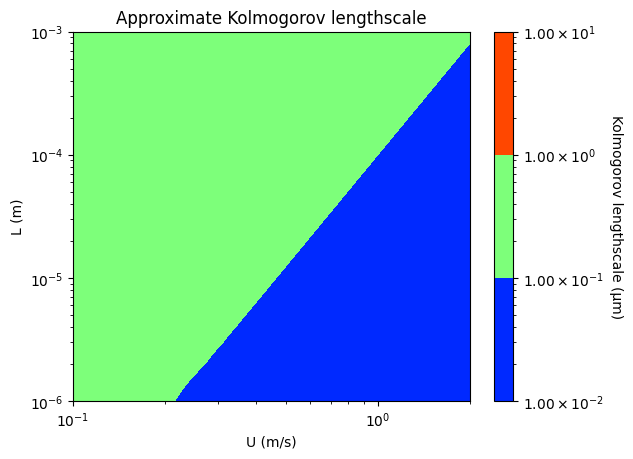

In [63]:
plot_kolm_lengthscale_UvsL(U_list, L_list, eta_array, U_log_scale = True, L_log_scale = True, eta_log_scale = True, colormap = 'jet', nbr_of_contours=10)

## Kolmogorv timescale approximate

### Kolmogorv timescale approximate plot depending on Re and caracteristic timescale T of system

In [64]:
def calculate_approx_kolm_timescale_RevsT_carac(Re_list, T_carac_list):
    """
    Function that calculates the approximate Kolmogorov timescale for a given range of T_carac and Re.
    
    Input:
    - Re_list: Array of Reynolds numbers
    - T_carac_list: Array of characteristic time values (in seconds)
    
    Output:
    - t_eta_array: Array of Kolmogorov timescale (approximate) for each pair of Re and L values (in seconds)
    """
    # Reshape the arrays for calculation
    Re_list_reshaped = np.reshape(Re_list, (len(Re_list), 1))
    T_carac_list_reshaped = np.reshape(T_carac_list, (len(T_carac_list), 1))

    # Calculate Kolmogorov timescale with t_eta =~ T_carac/(Re^0.5)
    Re_list_reshaped_raised_to_power = Re_list_reshaped**(-0.5)
    t_eta_array = T_carac_list_reshaped @ Re_list_reshaped_raised_to_power.T
    
    return t_eta_array

In [65]:
t_eta_array = calculate_approx_kolm_timescale_RevsT_carac(Re_list, T_carac_list)

In [66]:
def plot_kolm_timescale(Re_list, T_carac_list, t_eta_array, Re_log_scale=True, T_carac_log_scale=True, t_eta_log_scale=True, colormap='jet', nbr_of_countours=10):
    """
    Function that plots a colormap of the approximate Kolmogorov timescale for a given range of T_carac and Re.

    Inputs:
    - Re_list: List of Reynolds numbers
    - T_carac_list: List of characteristic times (in seconds)
    - t_eta_array: Array of Kolmogorov timescale values (in seconds)
    - Re_log_scale: Boolean indicating whether to use a logarithmic scale for the X axis (Re). Default is True.
    - T_carac_log_scale: Boolean indicating whether to use a logarithmic scale for the Y axis (T_carac). Default is True.
    - t_eta_log_scale: Boolean indicating whether to use a logarithmic scale for the colormap of t_eta. Default is True.
    - colormap: Colormap to use for the filled contour plot. Default is 'jet'.
    - nbr_of_countours: Number of contours to plot. Default is 10.

    Output:
    - Countour map of t_eta, i.e., the approximate Kolmogorov timescale.
    """

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Create the filled contour plot
    if t_eta_log_scale:
        fig = plt.contourf(Re_list, T_carac_list, t_eta_array, levels=nbr_of_countours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(Re_list, T_carac_list, t_eta_array, levels=nbr_of_countours, cmap=colormap)

    # Format function for scientific notation on axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    if Re_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if T_carac_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Kolmogorov timescale (s)', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Approximate Kolmogorov timescale')
    ax.set_xlabel('Re')
    ax.set_ylabel('T_carac (s)')

    # Show the plot
    plt.show()


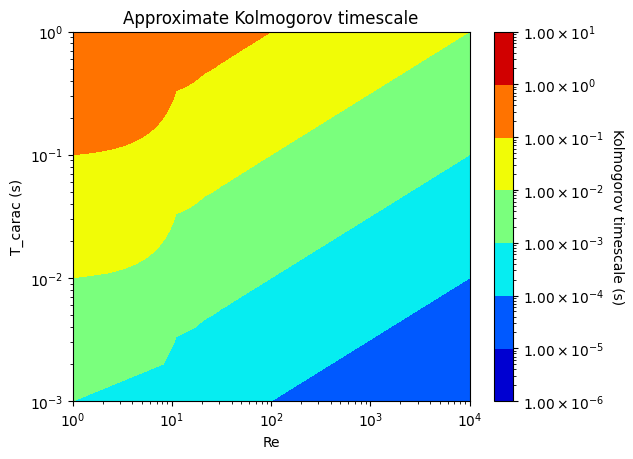

In [67]:
plot_kolm_timescale(Re_list, T_carac_list, t_eta_array, Re_log_scale = True, T_carac_log_scale = True, t_eta_log_scale = True, colormap = 'jet', nbr_of_countours = 10)

### Kolmogorv timescale approximate plot depending on U and L

In [68]:
def calculate_approx_kolm_timescale_UvsL(U_list, L_list, kinematic_viscosity):
    """
    Function that calculates the approximate Kolmogorov timescale for a given range of L and U.

    Input:
    - U_list: Array of characteristic speed values (in m/s)
    - L_list: Array of characteristic length values (in meters)
    - kinematic_viscosity: Kinematic viscosity of the fluid (in m^2/s)

    Output:
    - t_eta_array: Array of Kolmogorov timescale values (in seconds) for each pair of U and L values in the given range
    """
    # Create the data to calculate
    U_list_reshaped = np.reshape(U_list, (np.size(U_list), 1))
    L_list_reshaped = np.reshape(L_list, (np.size(L_list), 1))

    # Calculate Kolmogorov timescale with t_eta =~ (L * mu / U^3)^0.5
    numerator = kinematic_viscosity * L_list_reshaped
    denominator = U_list_reshaped ** -3
    t_eta_array = (numerator @ denominator.T) ** 0.5

    return t_eta_array


In [69]:
t_eta_array = calculate_approx_kolm_timescale_UvsL(U_list, L_list, kinematic_viscosity)

In [70]:
def plot_kolm_timescale_UvsL(U_list, L_list, t_eta_array, U_log_scale=True, L_log_scale=True, t_eta_log_scale=True, colormap='jet', nbr_of_contours=10):
    """
    Function that plots a colormap of the approximate Kolmogorov timescale for a given range of L and U.

    Input:
    - U_list: Array of characteristic speed values (in m/s)
    - L_list: Array of characteristic length values (in meters)
    - t_eta_array: Array of Kolmogorov timescale values (in seconds) for each pair of U and L values
    - U_log_scale: Boolean flag indicating whether to use a logarithmic scale for the X axis (default: True)
    - L_log_scale: Boolean flag indicating whether to use a logarithmic scale for the Y axis (default: True)
    - t_eta_log_scale: Boolean flag indicating whether to use a logarithmic scale for the colormap (default: True)
    - colormap: Name of the colormap to use (default: 'jet')
    - nbr_of_countours: Number of contour levels for the colormap (default: 10)
    """
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Create the filled contour plot
    if t_eta_log_scale:
        fig = plt.contourf(U_list, L_list, t_eta_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(U_list, L_list, t_eta_array, levels=nbr_of_contours, cmap=colormap)

    # Format func for scientific notation on axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    if U_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if L_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Kolmogorov timescale (s)', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Approximate Kolmogorov timescale')
    ax.set_xlabel('U (m/s)')
    ax.set_ylabel('L (m)')

    # Show the plot
    plt.show()


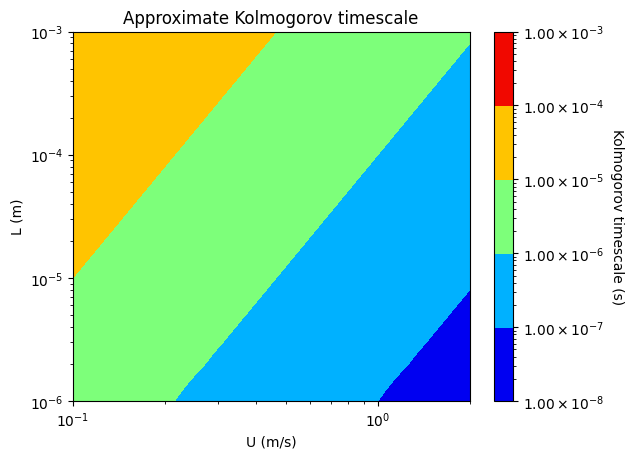

In [71]:
plot_kolm_timescale_UvsL(U_list, L_list, t_eta_array, U_log_scale = True, L_log_scale = True, t_eta_log_scale = True, colormap = 'jet', nbr_of_contours = 10)


# Taylor scale approximate

## Taylor length scale approximate

### Taylor lengthscale approximate plot depending on U and L

In [72]:
def calculate_approx_taylor_lengthscale_UvsL(U_list, L_list, kinematic_viscosity):
    """
    Function that calculates the approximate Taylor lengthscale for a given range of L and U.

    Input:
    - U_list: Array of characteristic speed values (in m/s)
    - L_list: Array of characteristic length values (in meters)
    - kinematic_viscosity: Kinematic viscosity (in m^2/s)

    Output:
    - lambda_array: Array of Taylor lengthscale values (in micrometers) for each pair of U and L values

    Formula: lambda =~ (10 * L * mu / U)^0.5
    """

    # Reshape the arrays to Nx1 arrays for matrix multiplication
    U_list_reshaped = np.reshape(U_list, (np.size(U_list), 1))
    L_list_reshaped = np.reshape(L_list, (np.size(L_list), 1))

    # Calculate Taylor lengthscale
    numerator = 10 * L_list_reshaped * kinematic_viscosity
    denominator = U_list_reshaped ** -1
    lambda_array = (numerator @ denominator.T) ** 0.5  # Values of Taylor lengthscale (Approximate) in meter
    lambda_array = lambda_array * 1e6  # Conversion to micrometers

    return lambda_array


In [73]:
lambda_array = calculate_approx_taylor_lengthscale_UvsL(U_list, L_list, kinematic_viscosity)

In [74]:
def plot_taylor_lengthscale_UvsL(U_list, L_list, lambda_array, U_log_scale=True, L_log_scale=True, lambda_array_log_scale=True, colormap='jet', nbr_of_contours=10):
    """
    Function that plots a colormap of the approximate Taylor lengthscale for a given range of L and U.

    Input:
    - U_list: Array of characteristic speed values (in m/s)
    - L_list: Array of characteristic length values (in meters)
    - lambda_array: Array of Taylor lengthscale values (in micrometers) for each pair of U and L values
    - U_log_scale: Boolean flag indicating whether to use a logarithmic scale for the X axis (default: True)
    - L_log_scale: Boolean flag indicating whether to use a logarithmic scale for the Y axis (default: True)
    - lambda_array_log_scale: Boolean flag indicating whether to use a logarithmic scale for the colormap (default: True)
    - colormap: Name of the colormap to use (default: 'jet')
    - nbr_of_countours: Number of contour levels for the colormap (default: 10)
    """
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Create the filled contour plot
    if lambda_array_log_scale:
        fig = plt.contourf(U_list, L_list, lambda_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(U_list, L_list, lambda_array, levels=nbr_of_contours, cmap=colormap)

    # Format func for scientific notation on axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    if U_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if L_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Taylor lengthscale (µm)', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Approximate Taylor lengthscale')
    ax.set_xlabel('U (m/s)')
    ax.set_ylabel('L (m)')

    # Show the plot
    plt.show()


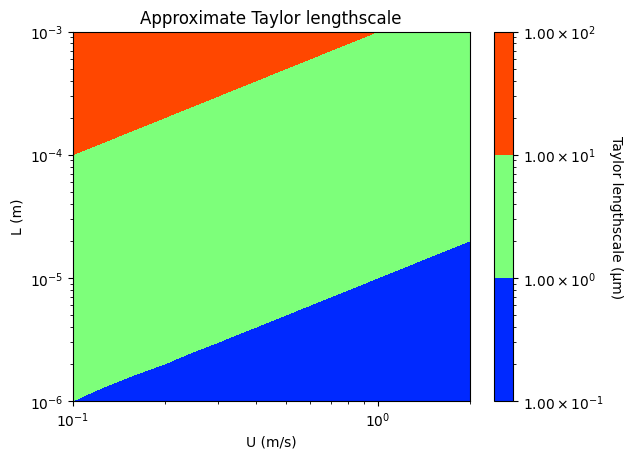

In [75]:
plot_taylor_lengthscale_UvsL(U_list, L_list, lambda_array, U_log_scale=True, L_log_scale=True, lambda_array_log_scale=True, colormap='jet', nbr_of_contours=10)


## Taylor time scale approximate

### Taylor timescale approximate plot depending on U and L

In [76]:
def calculate_approx_taylor_timescale_UvsL(U_list, L_list, kinematic_viscosity):
    """
    Function that calculates the approximate Taylor timescale for a given range of L and U.

    Input:
    - U_list: Array of characteristic speed values (in m/s)
    - L_list: Array of characteristic length values (in meters)
    - kinematic_viscosity: Kinematic viscosity (in m^2/s)

    Output:
    - t_lambda_array: Array of Taylor timescale values (in seconds) for each pair of U and L values

    Formula: t_lambda_array =~ (15 * L * mu / U^3)^0.5
    """

    # Reshape the arrays to Nx1 arrays for matrix multiplication
    U_list_reshaped = np.reshape(U_list, (np.size(U_list), 1))
    L_list_reshaped = np.reshape(L_list, (np.size(L_list), 1))

    # Calculate Taylor timescale
    numerator = 15 * L_list_reshaped * kinematic_viscosity
    denominator = U_list_reshaped ** -3
    t_lambda_array = (numerator @ denominator.T) ** 0.5  # Values of Taylor timescale (Approximate) in seconds

    return t_lambda_array


In [77]:
t_lambda_array = calculate_approx_taylor_timescale_UvsL(U_list, L_list, kinematic_viscosity)


In [78]:
def plot_taylor_timescale_UvsL(U_list, L_list, t_lambda_array, U_log_scale=True, L_log_scale=True, t_lambda_array_log_scale=True, colormap='jet', nbr_of_contours=10):
    """
    Function that plots a colormap of the approximate Taylor timescale for a given range of L and U.

    Input:
    - U_list: Array of characteristic speed values (in m/s)
    - L_list: Array of characteristic length values (in meters)
    - t_lambda_array: Array of Taylor timescale values (in seconds) for each pair of U and L values
    - U_log_scale: Boolean flag indicating whether to use a logarithmic scale for the X axis (default: True)
    - L_log_scale: Boolean flag indicating whether to use a logarithmic scale for the Y axis (default: True)
    - t_lambda_array_log_scale: Boolean flag indicating whether to use a logarithmic scale for the colormap (default: True)
    - colormap: Name of the colormap to use (default: 'jet')
    - nbr_of_countours: Number of contour levels for the colormap (default: 10)
    """
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Create the filled contour plot
    if t_lambda_array_log_scale:
        fig = plt.contourf(U_list, L_list, t_lambda_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(U_list, L_list, t_lambda_array, levels=nbr_of_contours, cmap=colormap)

    # Format func for scientific notation on axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    if U_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if L_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Taylor timescale (s)', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Approximate Taylor timescale')
    ax.set_xlabel('U (m/s)')
    ax.set_ylabel('L (m)')

    # Show the plot
    plt.show()


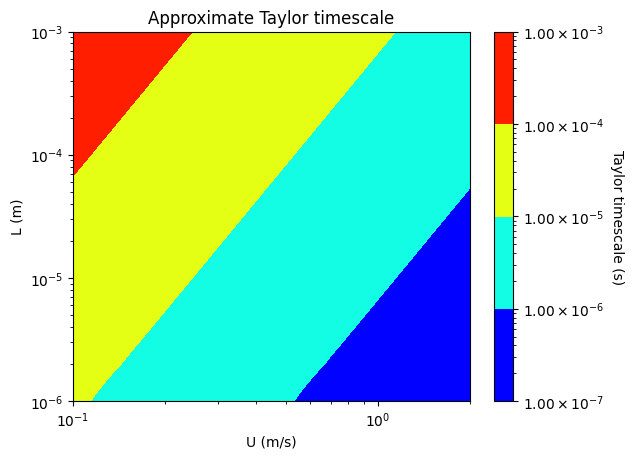

In [79]:
plot_taylor_timescale_UvsL(U_list, L_list, t_lambda_array, U_log_scale=True, L_log_scale=True, t_lambda_array_log_scale=True, colormap='jet', nbr_of_contours=10)


# Batchelor scale approximate

## Batchelor lenghtscale approximate

### Batchelor lenghtscale approximate plot depending on U and L

In [80]:
# Formula: batchelor_lengthscale = kolmogorov_lengthscale/sqrt(Sc), see ref on wikipedia Batchelor scale

lambda_batchelor_array = eta_array/np.sqrt(schmidt_number)

In [81]:
def plot_batchelor_lenghtscale_UvsL(U_list, L_list, lambda_batchelor_array, U_log_scale=True, L_log_scale=True, lambda_batchelor_log_scale=True, colormap='jet', nbr_of_contours=10):
    """
    Function that plots a colormap of the approximate Batchelor lenghtscale for a given range of L and U.

    Input:
    - U_list: Array of characteristic speed values (in m/s)
    - L_list: Array of characteristic length values (in meters)
    - lambda_batchelor_array: Array of Batchelor lenghtscale values (in micro meters) for each pair of U and L values
    - U_log_scale: Boolean flag indicating whether to use a logarithmic scale for the X axis (default: True)
    - L_log_scale: Boolean flag indicating whether to use a logarithmic scale for the Y axis (default: True)
    - lambda_batchelor_log_scale: Boolean flag indicating whether to use a logarithmic scale for the colormap (default: True)
    - colormap: Name of the colormap to use (default: 'jet')
    - nbr_of_countours: Number of contour levels for the colormap (default: 10)
    """
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Create the filled contour plot
    if lambda_batchelor_log_scale:
        fig = plt.contourf(U_list, L_list, lambda_batchelor_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(U_list, L_list, lambda_batchelor_array, levels=nbr_of_contours, cmap=colormap)

    # Format func for scientific notation on axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    if U_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if L_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Batchelor lenghtscale (µm)', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Approximate Batchelor lenghtscale')
    ax.set_xlabel('U (m/s)')
    ax.set_ylabel('L (m)')

    # Show the plot
    plt.show()


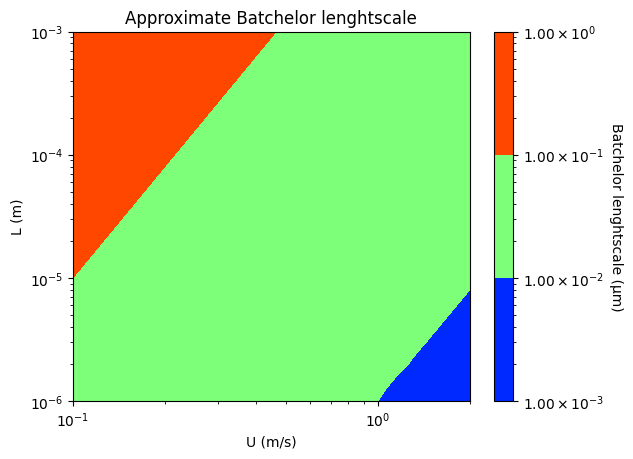

In [82]:
plot_batchelor_lenghtscale_UvsL(U_list, L_list, lambda_batchelor_array, U_log_scale=True, L_log_scale=True, lambda_batchelor_log_scale=True, colormap='jet', nbr_of_contours=10)


### Batchelor timescale approximate plot depending on U and L

In [83]:
## ???? Can i define a Batchelor timescale ?

# Integral scale approximate

Is it relevant ?? In the sense that I used l_integral ~ L in the previous calculation and that we should at least expect to see this scale of turbulence with our sensors

# Time vs spatial resolution

In [92]:
"""
Dummy data that serves as a placeholder for the plot, to replace with real values once they are obtained
"""

#L = 1e-6 #in meters, To specify
#U = 1e0 # in m/s, To specify
#T = 1e-6 #in seconds

turbulent_timescales_values = [1e-8, 1e-7, 1e-6] #List of turbulent approximate timescales values for given L and U values (integral, Taylor, Batchelor, Kolmogorov... see Pope's turbulence book for ref), in seconds
turbulent_lengthscales_values = [1e-9, 1e-8, 1e-7, 1e-6] #List of turbulent approximate lengthscales values for given L and U values (integral, Taylor, Batchelor, Kolmogorov... see Pope's turbulence book for ref), in meters

turbulent_timescales_labels = ['Kolm','Taylor','Int'] #List of turbulent timescales labels for each numerical value
turbulent_lengthscales_labels = ['Kolm','Batch','Taylor','Int'] #List of turbulent lengthscale labels for each numerical value


sensor_labels = ['sensor_type_1'] #List of the different sensor tech names
spatial_resolutions = [1e-7] #List of the different sensor techs approxiamte spatial resolution limits in meters
temporal_resolutions = [1e-8] #List of the different sensor techs approxiamte temporal resolution limits in seconds


#Max values
#T = max(turbulent_timescales_values)
#L = max(turbulent_lengthscales_values)

#Min values
#min_l = min(turbulent_lengthscales_values)
#min_t = min(turbulent_timescales_values)



In [123]:
def plot_time_vs_spatial_resolution(turbulent_timescales_values, turbulent_timescales_labels, turbulent_lengthscales_values, turbulent_lengthscales_labels, sensor_labels, spatial_resolutions, temporal_resolutions, color_zones=True):
    """
    Plots the sensors' spatial and temporal resolution limits compared to turbulent spatial and temporal scales at a given flow.

    Args:
        turbulent_timescales_values (list): List of turbulent timescale values.
        turbulent_timescales_labels (list): List of turbulent timescale labels.
        turbulent_lengthscales_values (list): List of turbulent lengthscales values.
        turbulent_lengthscales_labels (list): List of turbulent lengthscales labels.
        sensor_labels (list): List of labels for the sensors.
        spatial_resolutions (list): List of spatial resolutions of the sensors.
        temporal_resolutions (list): List of temporal resolutions of the sensors.
        color_zones (bool, optional): Flag indicating whether to add color zones. Defaults to True.

    Returns:
        None
    """
    # Max values
    T = max(turbulent_timescales_values)
    L = max(turbulent_lengthscales_values)
    
    # Min values
    min_l = min(turbulent_lengthscales_values)
    min_t = min(turbulent_timescales_values)
    
    color_list = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    
    # Create Figure and Axes objects
    fig, ax = plt.subplots()

    # Set labels for X and Y axes
    ax.set_xlabel('Turbulence lengthscales (m)')
    ax.set_ylabel('Turbulence timescales (s)')

    # Set the limits for X and Y axes
    ax.set_xlim(min_l / 10, L * 10)  # X-axis limits from min_l/10 to L*10
    ax.set_ylim(min_t / 10, T * 10)  # Y-axis limits from min_t/10 to T*10
    
    # Add vertical and horizontal lines corresponding to sensors spatiotemporal resolutions
    for index, label in enumerate(sensor_labels):
        ax.axvline(x=spatial_resolutions[index], color=color_list[index], linestyle='--', label=label)  # Vertical line at x=spatial_resolutions[index]
        ax.axhline(y=temporal_resolutions[index], color=color_list[index], linestyle='--')  # Horizontal line at y=temporal_resolutions[index]
        if color_zones:
            # Add a horizontal span between y=0 and y=temporal_resolutions[index]
            ax.axhspan(0, temporal_resolutions[index], color=color_list[index], alpha=0.3, hatch = '/', label = 'temporal limit')
            # Add a label for the horizontal span
            #ax.annotate(label, xy=(0.5*spatial_resolutions[index], 0.5*temporal_resolutions[index]), xytext=(10, 0), textcoords='offset points', ha='center', va='center')


            # Add a vertical span between x=0 and x=spatial_resolutions[index]
            ax.axvspan(0, spatial_resolutions[index], color=color_list[index], alpha=0.3, hatch = '\\', label = 'spatial limit')
             # Add a label for the vertical span
            #ax.annotate(label, xy=(0.5*spatial_resolutions[index], 0.5*temporal_resolutions[index]), xytext=(0, 10), textcoords='offset points', ha='center', va='center')


    # Set axis scale to log
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Set custom tick positions and labels for the X-axis
    xticks = turbulent_lengthscales_values
    xtick_labels = [f"{label} = {value}" for label, value in zip(turbulent_lengthscales_labels, turbulent_lengthscales_values)]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, rotation=45, ha='right')

    # Set custom tick positions and labels for the Y-axis
    yticks = turbulent_timescales_values
    ytick_labels = [f"{label} = {value}" for label, value in zip(turbulent_timescales_labels, turbulent_timescales_values)]
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)

    # Add a legend
    ax.legend()

    # Set title for the plot
    ax.set_title('Observable turbulent scales domains')

    # Display the plot
    plt.show()


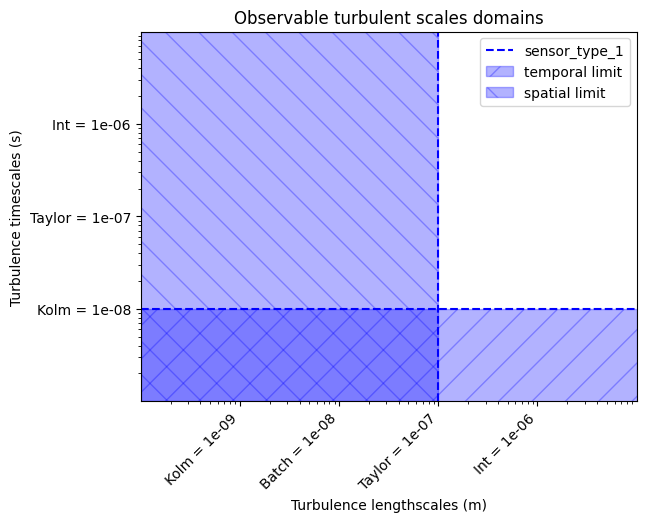

In [124]:
plot_time_vs_spatial_resolution(turbulent_timescales_values, turbulent_timescales_labels, turbulent_lengthscales_values, turbulent_lengthscales_labels, sensor_labels, spatial_resolutions, temporal_resolutions, color_zones = True)

# Dimensionless caracterisation of scale

## Dimensionless numbers computation functions

In [25]:
def calculate_reynolds_number(U, L, nu):
    """
    Calculate the Reynolds number for a given flow.

    Args:
        U (float): Velocity of the flow (in m/s).
        L (float): Characteristic length (in meters).
        nu (float): Kinematic viscosity (in m^2/s).

    Returns:
        float: The Reynolds number.

    """
    # Calculate the Reynolds number using the formula: Re = (U * L) / nu
    Re = (U * L) / nu

    # Return the Reynolds number
    return Re

def calculate_eckert_number(U, c_p, delta_T):
    """
    Calculate the Eckert number for a given flow.

    Args:
        U (float): Velocity of the flow (in m/s).
        c_p (float): Specific heat capacity at constant pressure (in J/(kg*K)).
        delta_T (float): Temperature difference (in K).

    Returns:
        float: The Eckert number.

    """
    # Calculate the Eckert number using the formula: Ec = U^2 / (c_p * delta_T)
    Ec = (U ** 2) / (c_p * delta_T)

    # Return the Eckert number
    return Ec

def calculate_prandtl_number(mu, c_p, kappa):
    """
    Calculate the Prandtl number for a given fluid.

    Args:
        mu (float): Dynamic viscosity of the fluid (in kg/(m*s)).
        c_p (float): Specific heat capacity at constant pressure (in J/(kg*K)).
        kappa (float): Thermal conductivity of the fluid (in W/(m*K)).

    Returns:
        float: The Prandtl number.

    """
    # Calculate the Prandtl number using the formula: Pr = mu * c_p / kappa
    Pr = mu * c_p / kappa

    # Return the Prandtl number
    return Pr

def calculate_froude_number(U, L, g = 9.81):
    """
    Calculate the Froude number for a given flow.

    Args:
        U (float): Velocity of the flow (in m/s).
        g (float): Gravitational acceleration (in m/s^2).
        L (float): Characteristic length of the flow (in meters).

    Returns:
        float: The Froude number.

    """
    # Calculate the Froude number using the formula: Fr = U / sqrt(g * L)
    Fr = U / ((g * L) ** 0.5)

    # Return the Froude number
    return Fr


def calculate_mach_number(U, sos):
    """
    Calculate the Mach number for a given flow.

    Args:
        U (float): Velocity of the flow (in m/s).
        sos (float): Speed of sound in the medium (in m/s).

    Returns:
        float: The Mach number.

    """
    # Calculate the Mach number using the formula: Ma = U / sos
    Ma = U / sos

    # Return the Mach number
    return Ma


## Study of N2

In [28]:
#T and P ranges to investigates, modify as desired
P_list = P_list_generator(P_min = 1, P_max = 1e3, P_number_of_points = 1000) #in bars
T_list = T_list_generator( T_min=1,T_max=1e3,T_number_of_points=1000) # in Celsius

# Conversion to SI for T and P
P_list = P_list * 1e5 #in Pascals
T_list = T_list + 273.15 #in Kelvin

#Defining flow parameters
U = 1e0 # (in m/s).
L = 1e-6 # in meters

In [37]:
# Calculation of the various thermodynamic functions (rho, mu, kappa, c_p, sos...) using Peng-Robinson model as well as High-pressure gas model from Ouriol's code

# Definition of constant for N2
molecular_weight = 28.0134  # Molecular weight of N2 in g/mol
acentric_factor = 0.0372  # Acentric factor of N2
critical_temperature = 126.2  # Critical temperature of N2 in K
critical_pressure: 3395800.0    # Critical pressure [Pa]
critical_molar_volume: 0.000089412  # Critical molar volume [m3/mol]


# NASA 7-coefficient polynomial (15 values)
NASA_coefficients = np.array([ 2.952576370000000000000,
                        0.001396900400000000000,
                       -0.000000492631603000000,
                        0.000000000078601019000,
                       -0.000000000000004607552,
                       -923.9486880000000000000,
                        5.871887620000000000000,
                        3.531005280000000000000,
                       -0.000123660980000000000,
                       -0.000000502999433000000,
                        0.000000002435306120000,
                       -0.000000000001408812400,
                       -1046.976280000000000000,
                        2.967470380000000000000,
                        0.000000000000000000000])
                       
# Creation of a N2 gas objet, instance of Peng Robinson class
n2_gas = PengRobinsonModel(
    molecular_weight=molecular_weight,
    acentric_factor=acentric_factor,
    critical_temperature=critical_temperature,
    critical_pressure=critical_pressure,
    critical_molar_volume=critical_molar_volume,
    NASA_coefficients=NASA_coefficients
    
)


# Rho

#Rho_list = 

# Mu

# Kappa

# C_p

# Sos






In [56]:
rho, e = n2_gas.calculateDensityInternalEnergyFromPressureTemperature(None,None,100e5,300)
rho


The PengRobinsonModel::calculateRootsCubicPolynomial has found more than one real root.
Vapor-liquid equilibrium conditions must be solved.
Another option is to avoid calculating rho from P and T.



ZeroDivisionError: float division by zero

In [45]:
help(n2_gas.calculateDensityInternalEnergyFromPressureTemperature)

Help on method calculateDensityInternalEnergyFromPressureTemperature in module __main__:

calculateDensityInternalEnergyFromPressureTemperature(rho, e, P, T) method of __main__.PengRobinsonModel instance



# Test

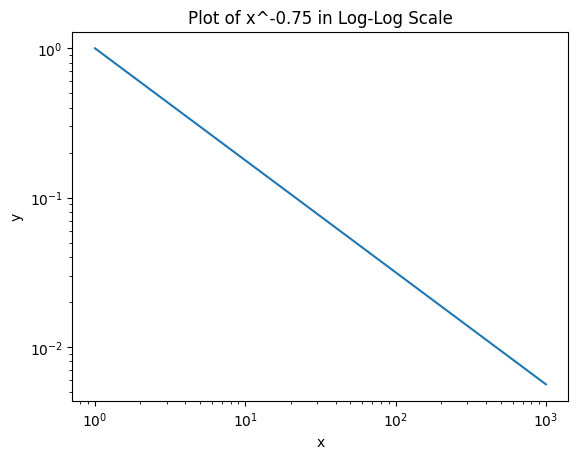

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values from 1 to 1000
x = np.logspace(0, 3, 1000)

# Calculate y values using the function x^(-0.75)
y = x ** -0.75

# Create the log-log plot
plt.loglog(x, y)

# Set plot labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of x^-0.75 in Log-Log Scale')

# Display the plot
plt.show()
